In [1]:
import numpy as np
import seaborn as sb
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot as plt
import missingno as msno
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:

df=pd.read_csv("diabetes.csv")
#Adım 1: Genel resmi inceleyiniz
def check_df(dataframe, head=5): 
    print("################ Shape ##################")
    print(dataframe.shape)
    print("################ Types ##################")
    print(dataframe.dtypes)
    print("################ Head ##################")
    print(dataframe.head(head))
    print("################ Tail ##################")
    print(dataframe.tail(head))
    print("################ NA ##################")
    print(dataframe.isnull().sum())
    print("################ Quantiles ##################")
    print(dataframe.describe([0, 0.05, 0.5, 0.95, 0.99, 1]).T)
    print("#################### END ###################")

check_df(df)

################ Shape ##################
(768, 9)
################ Types ##################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
################ Head ##################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1

In [3]:
#Adım 2: Numerik ve kategorik değişkenleri yakalayınız
#Adım 3: Numerik ve kategorik değişkenlerin analizini yapınız.

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != 'O']
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == 'O']
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols,num_cols

grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


(['Outcome'],
 ['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'])

         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896


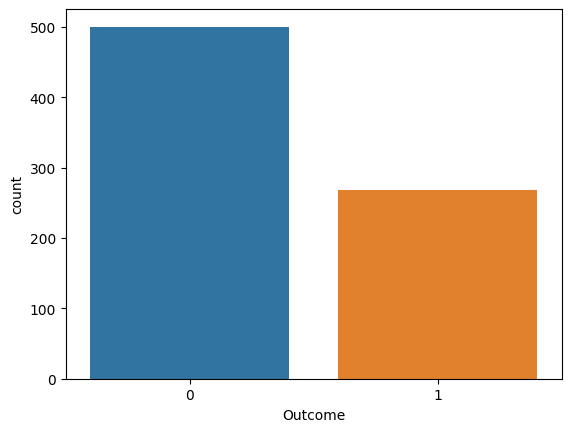

In [4]:
#Adım 3: Numerik ve kategorik değişkenlerin analizini yapınız
#Kategorik Degisken Analizi


def cat_summary(dataframe,col_name,plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio":100*dataframe[col_name].value_counts()/ len(dataframe)}))
    if plot:
        sb.countplot(x=dataframe[col_name],data=dataframe)
        plt.show()


cat_summary(df,"Outcome",True)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
Pregnancies
count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
75%       6.000
80%       7.000
90%       9.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


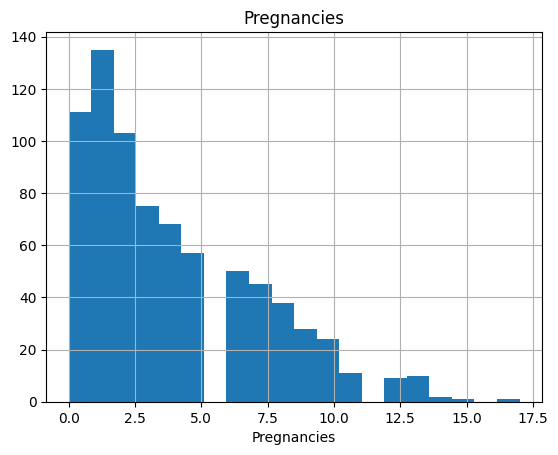

Glucose
count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
75%     140.250
80%     147.000
90%     167.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


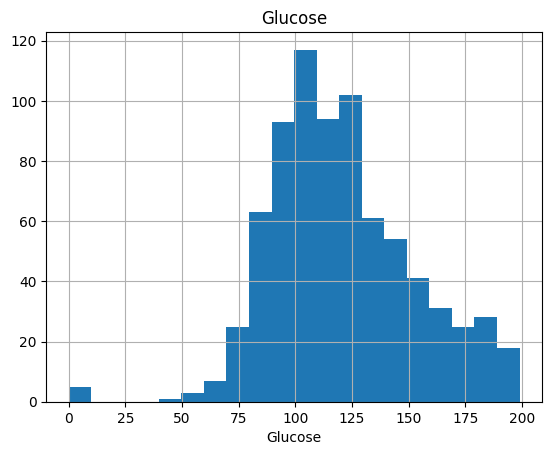

BloodPressure
count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
75%      80.000
80%      82.000
90%      88.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64


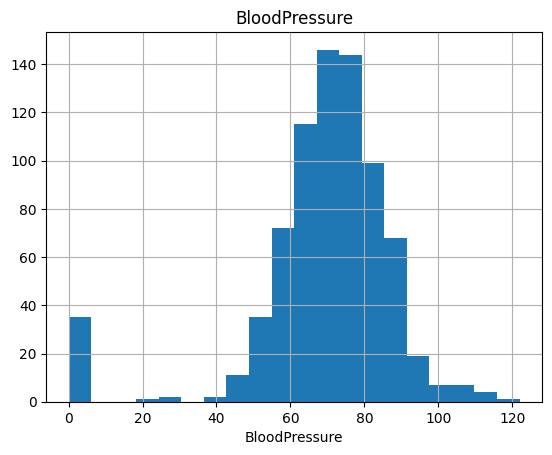

SkinThickness
count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
75%      32.000
80%      35.000
90%      40.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


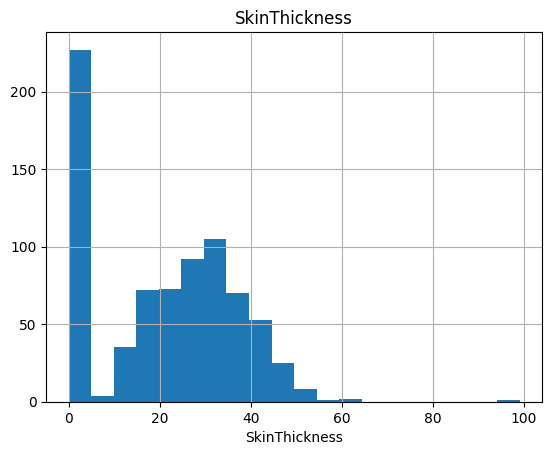

Insulin
count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
75%     127.250
80%     150.000
90%     210.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


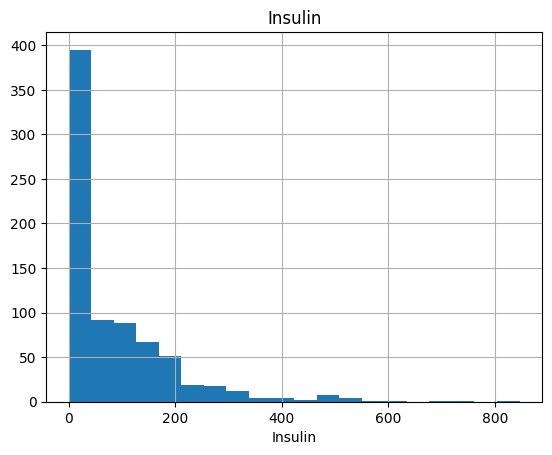

BMI
count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
75%      36.600
80%      37.800
90%      41.500
99%      50.759
max      67.100
Name: BMI, dtype: float64


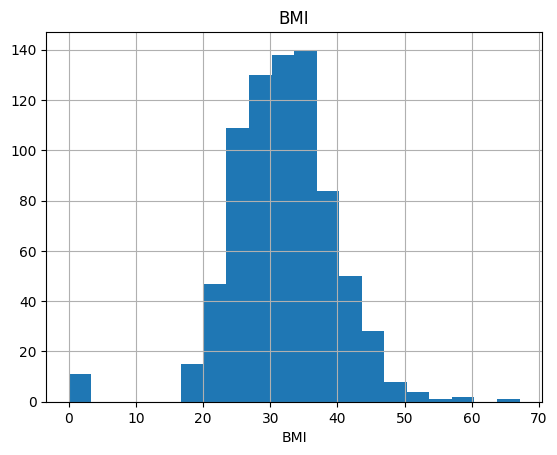

DiabetesPedigreeFunction
count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
75%       0.626
80%       0.687
90%       0.879
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


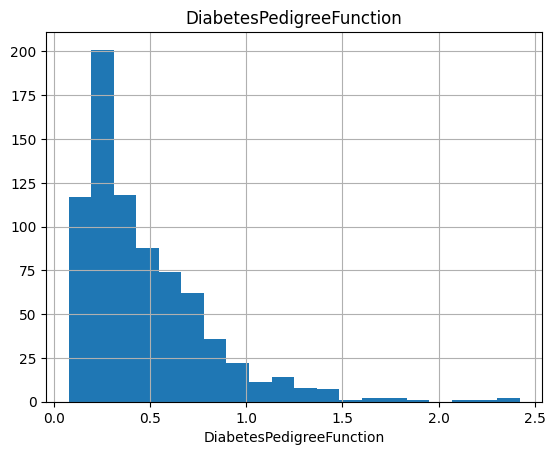

Age
count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
75%      41.000
80%      42.600
90%      51.000
99%      67.000
max      81.000
Name: Age, dtype: float64


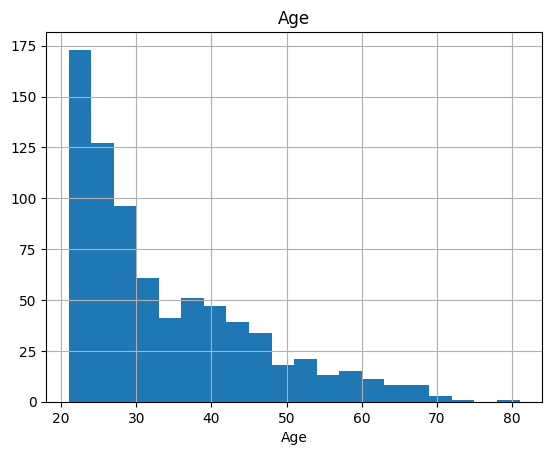

In [5]:
#Numerik Değişken Analizi

def num_summary(dataframe,num_col,plot:False):
    quantiles=[0.05,0.10,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.9,0.99]
    print(num_col)
    print(dataframe[num_col].describe(quantiles).T)
    if plot:
        dataframe[num_col].hist(bins=20)
        plt.xlabel(num_col)
        plt.title(num_col)
        plt.show()
cat_cols,num_cols=grab_col_names(df)

for col in num_cols:
    num_summary(df,col,True)

In [6]:

#Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre 
#numerik değişkenlerin ortalaması

def target(dataframe,target,caterigolcol):
    print( pd.DataFrame({"TARGET_MEAN": dataframe.groupby(caterigolcol)[target].mean()}))

cat_cols,num_cols= grab_col_names(df)
for col in cat_cols:
    target(df,"Outcome",col)

for col in num_cols:
    target(df,col,"Outcome")

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
         TARGET_MEAN
Outcome             
0              0.000
1              1.000
         TARGET_MEAN
Outcome             
0              3.298
1              4.866
         TARGET_MEAN
Outcome             
0            109.980
1            141.257
         TARGET_MEAN
Outcome             
0             68.184
1             70.825
         TARGET_MEAN
Outcome             
0             19.664
1             22.164
         TARGET_MEAN
Outcome             
0             68.792
1            100.336
         TARGET_MEAN
Outcome             
0             30.304
1             35.143
         TARGET_MEAN
Outcome             
0              0.430
1              0.550
         TARGET_MEAN
Outcome             
0             31.190
1             37.067


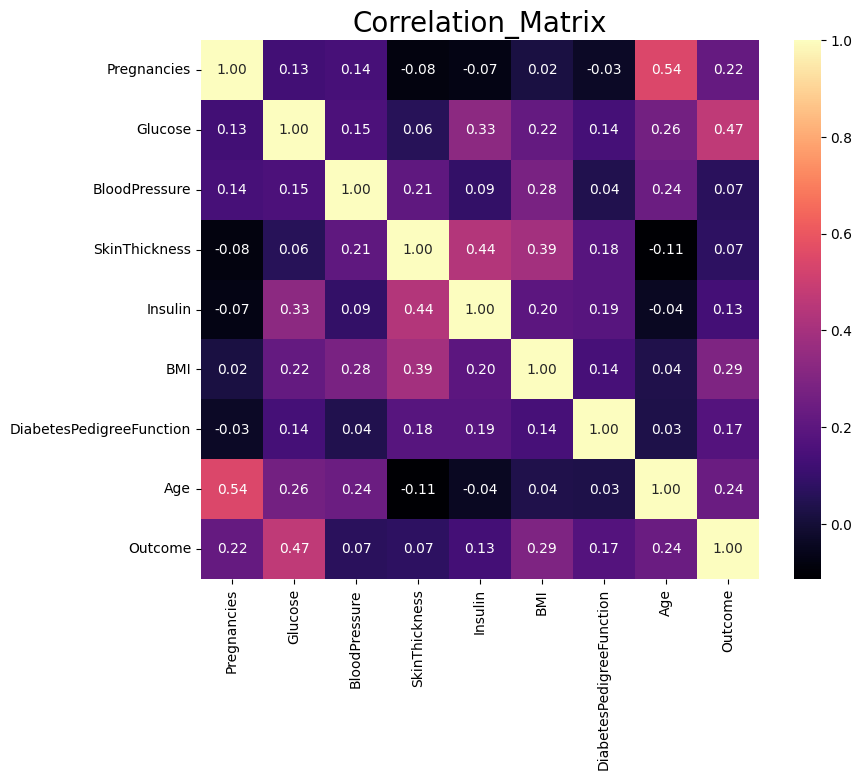

In [7]:
#Adım 7: Korelasyon analizi yapınız.

corr=df.corr()
f,ax=plt.subplots(figsize=[9,7])
sb.heatmap(corr,annot=True,fmt=".2f",ax=ax,cmap="magma")
ax.set_title("Correlation_Matrix",fontsize=20)
plt.show(block=True)

In [8]:
#Base Model Oluşumu
y = df["Outcome"]
X = df.drop("Outcome", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)



print(f"Accuarcy:{round(accuracy_score(y_pred, y_test),2) }")
print(f"Recall :{round(recall_score(y_pred,y_test),3)}")
print(f"Precision :{round(precision_score(y_pred,y_test),2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}") 



Accuarcy:0.77
Recall :0.706
Precision :0.59
F1: 0.64
Auc: 0.75


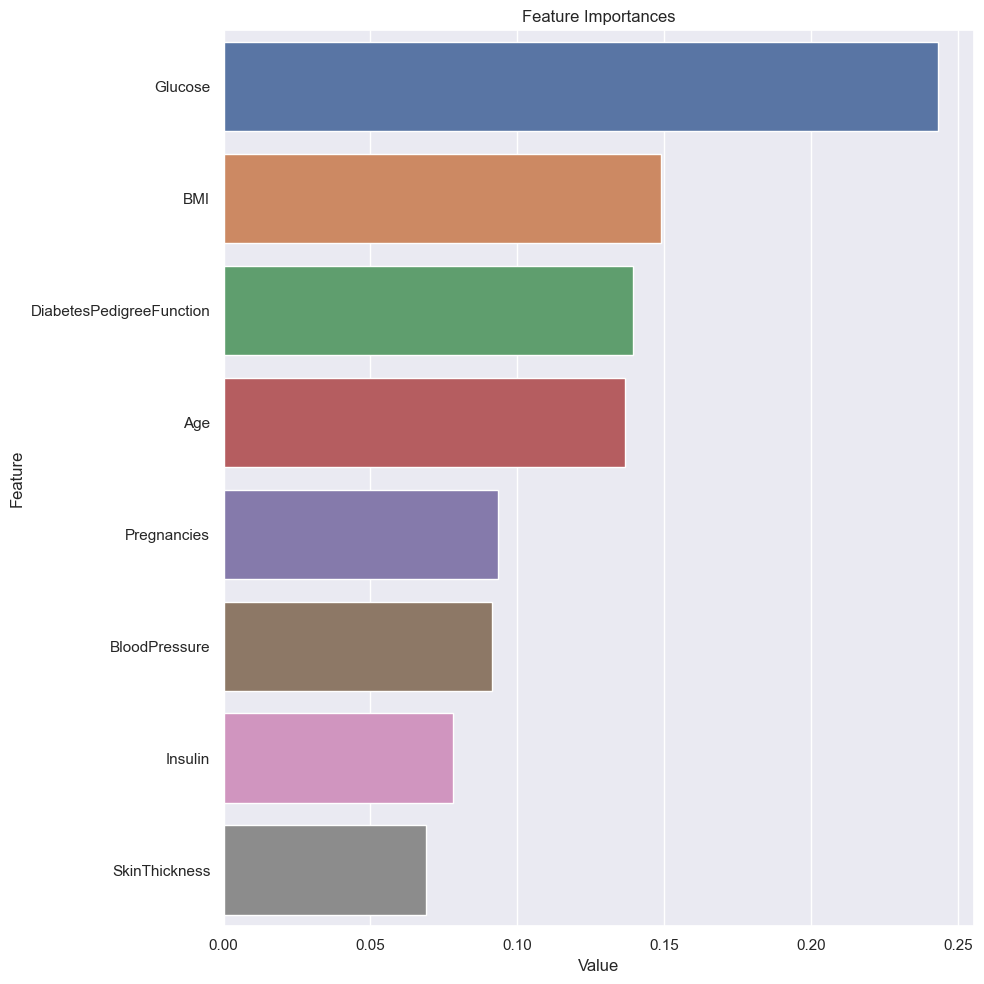

In [9]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sb.set(font_scale=1)
    sb.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:num])
    plt.title('Feature Importances')
    plt.tight_layout()
    if save:
        plt.savefig('importances.png')
    else:
        plt.show()

plot_importance(rf_model,X)

In [10]:
#Adım 6: Eksik gözlem analizi yapınız.
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [11]:
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

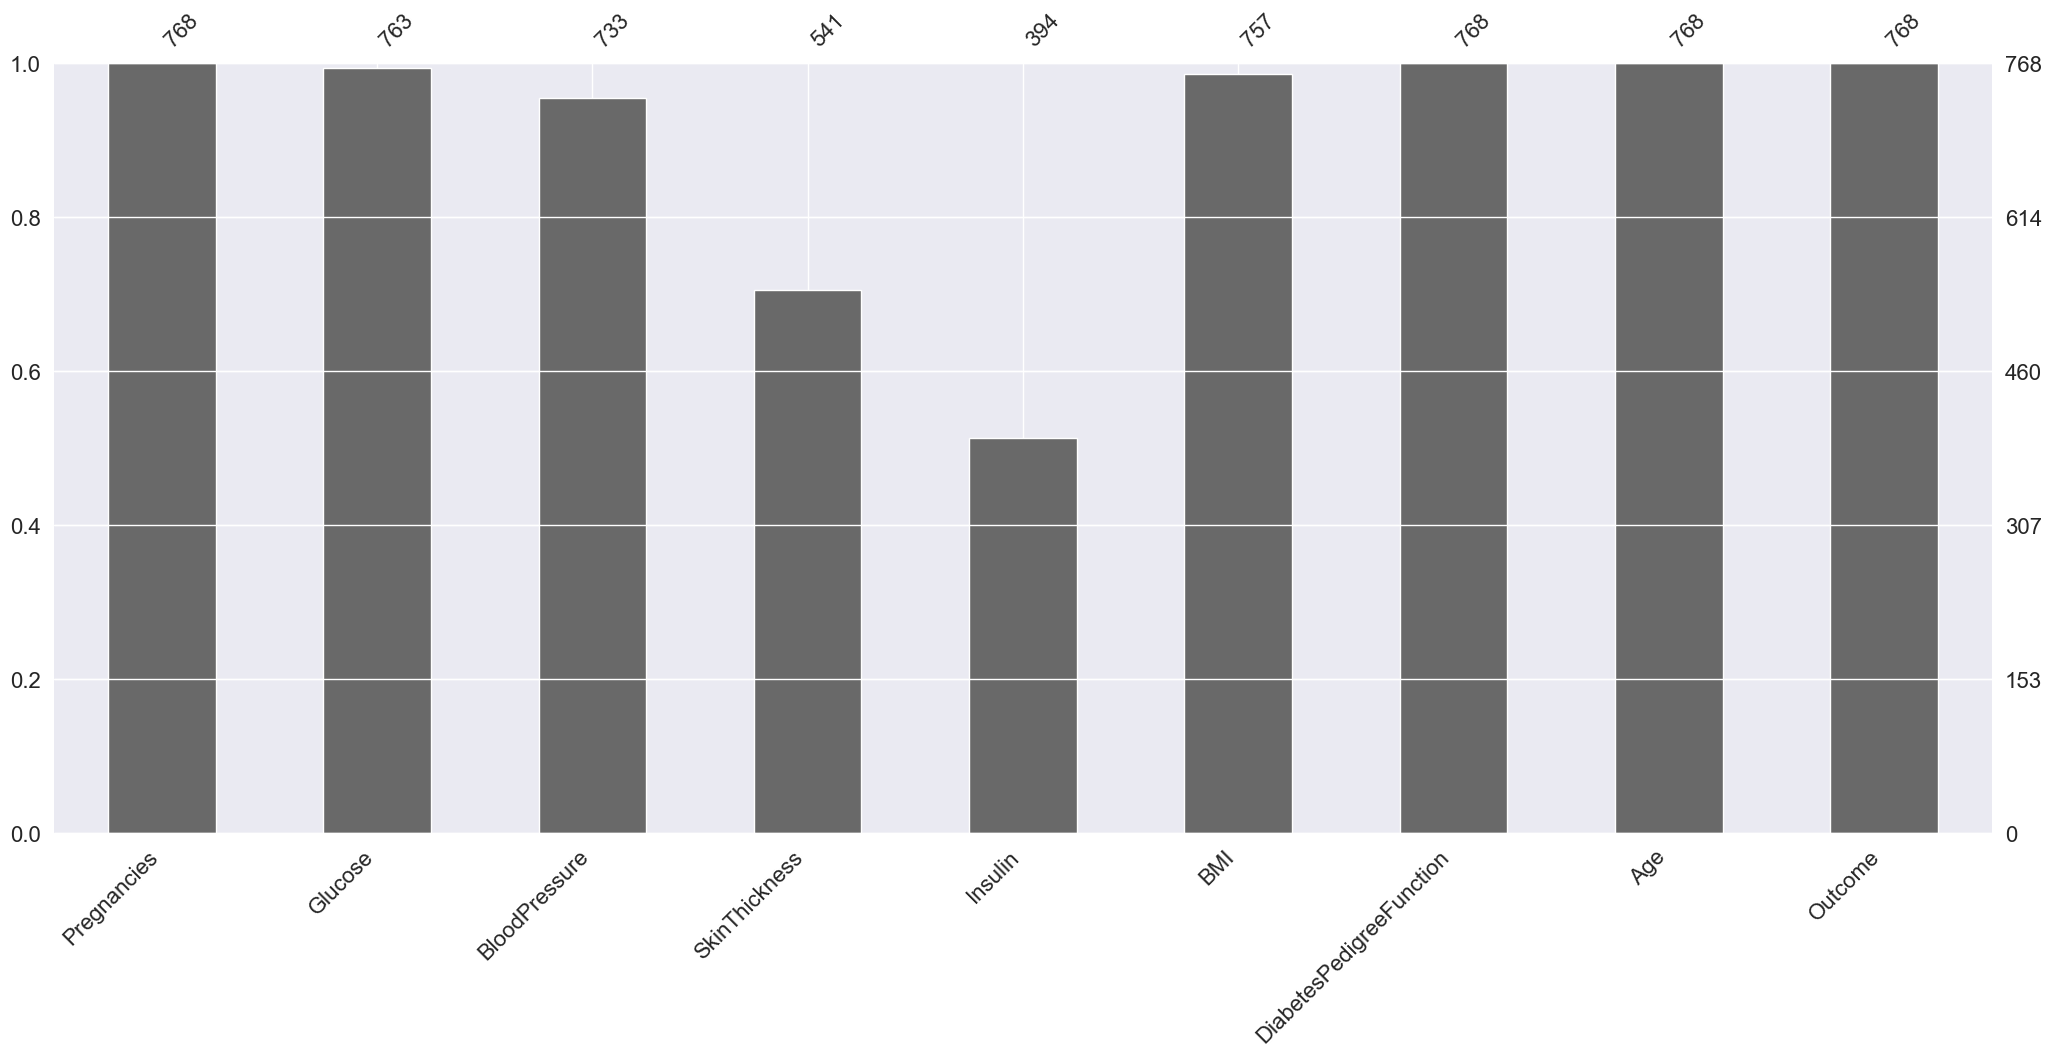

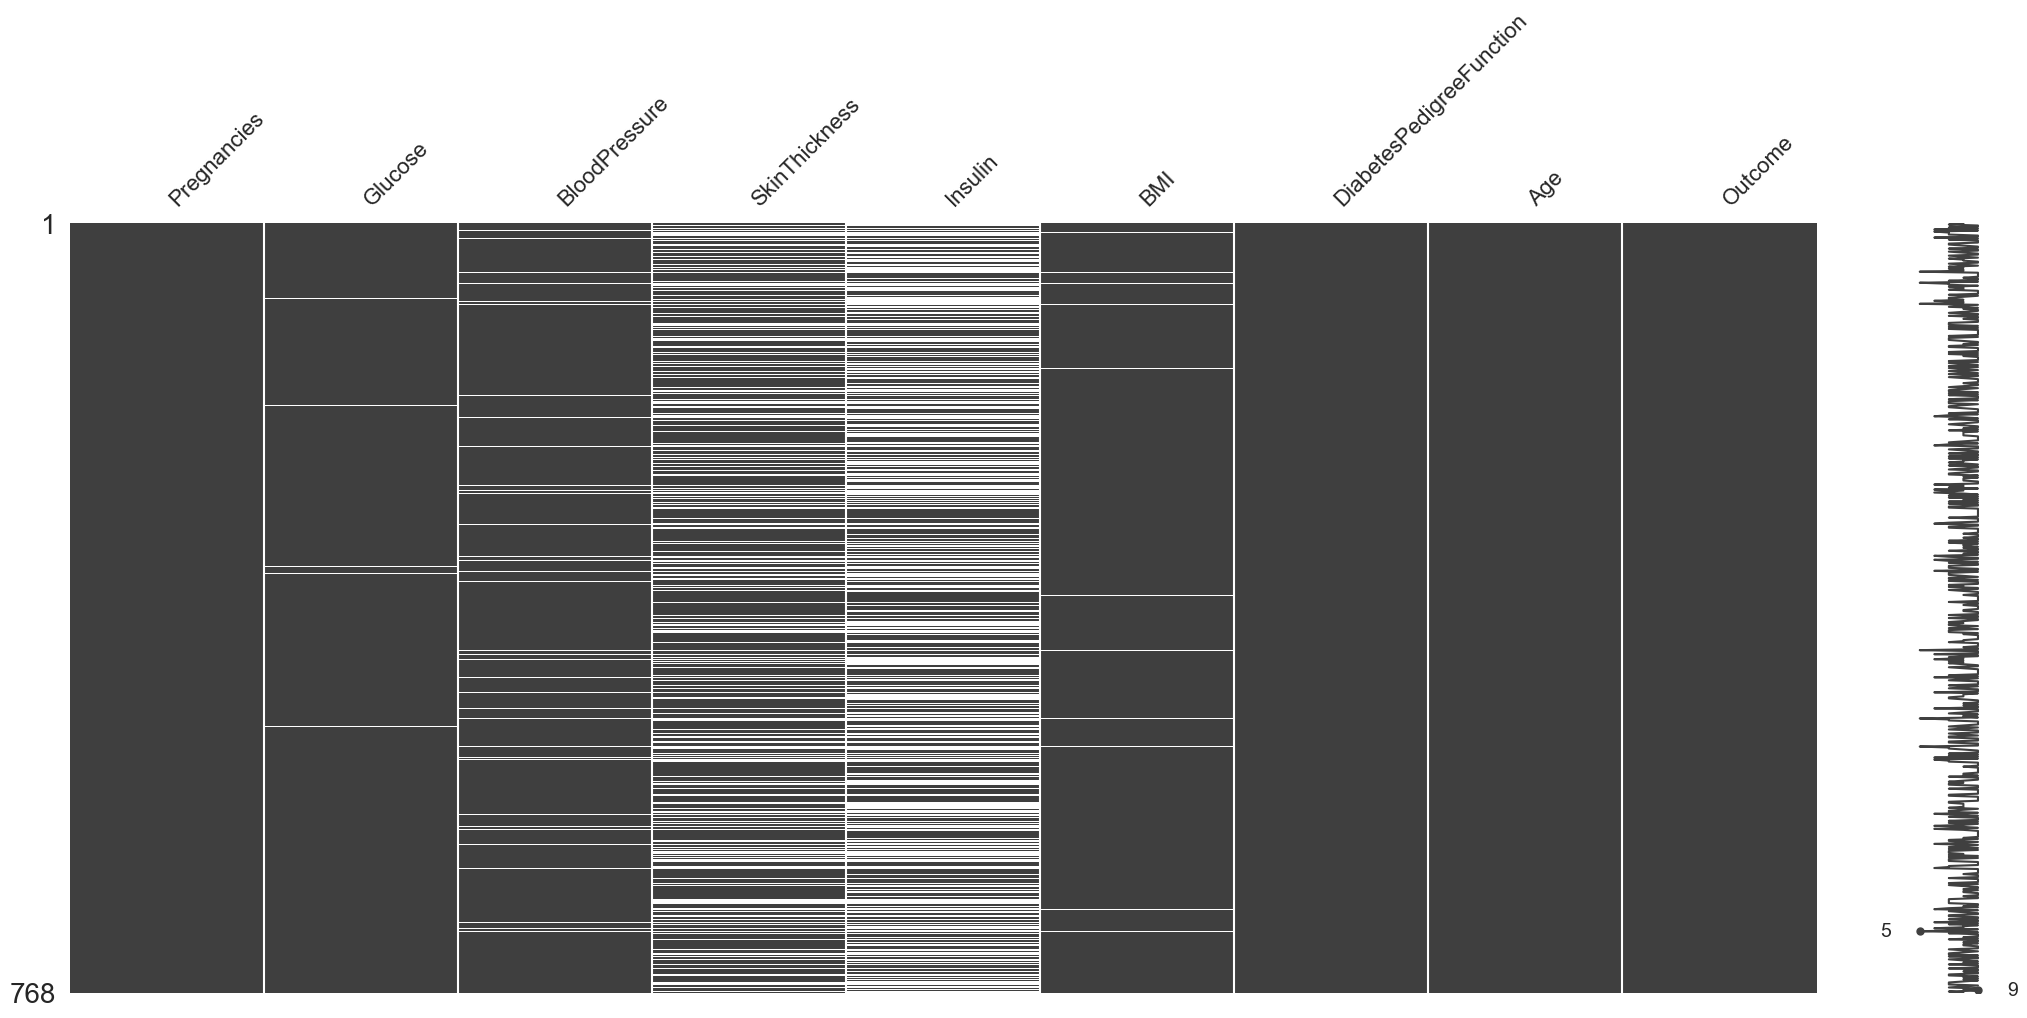

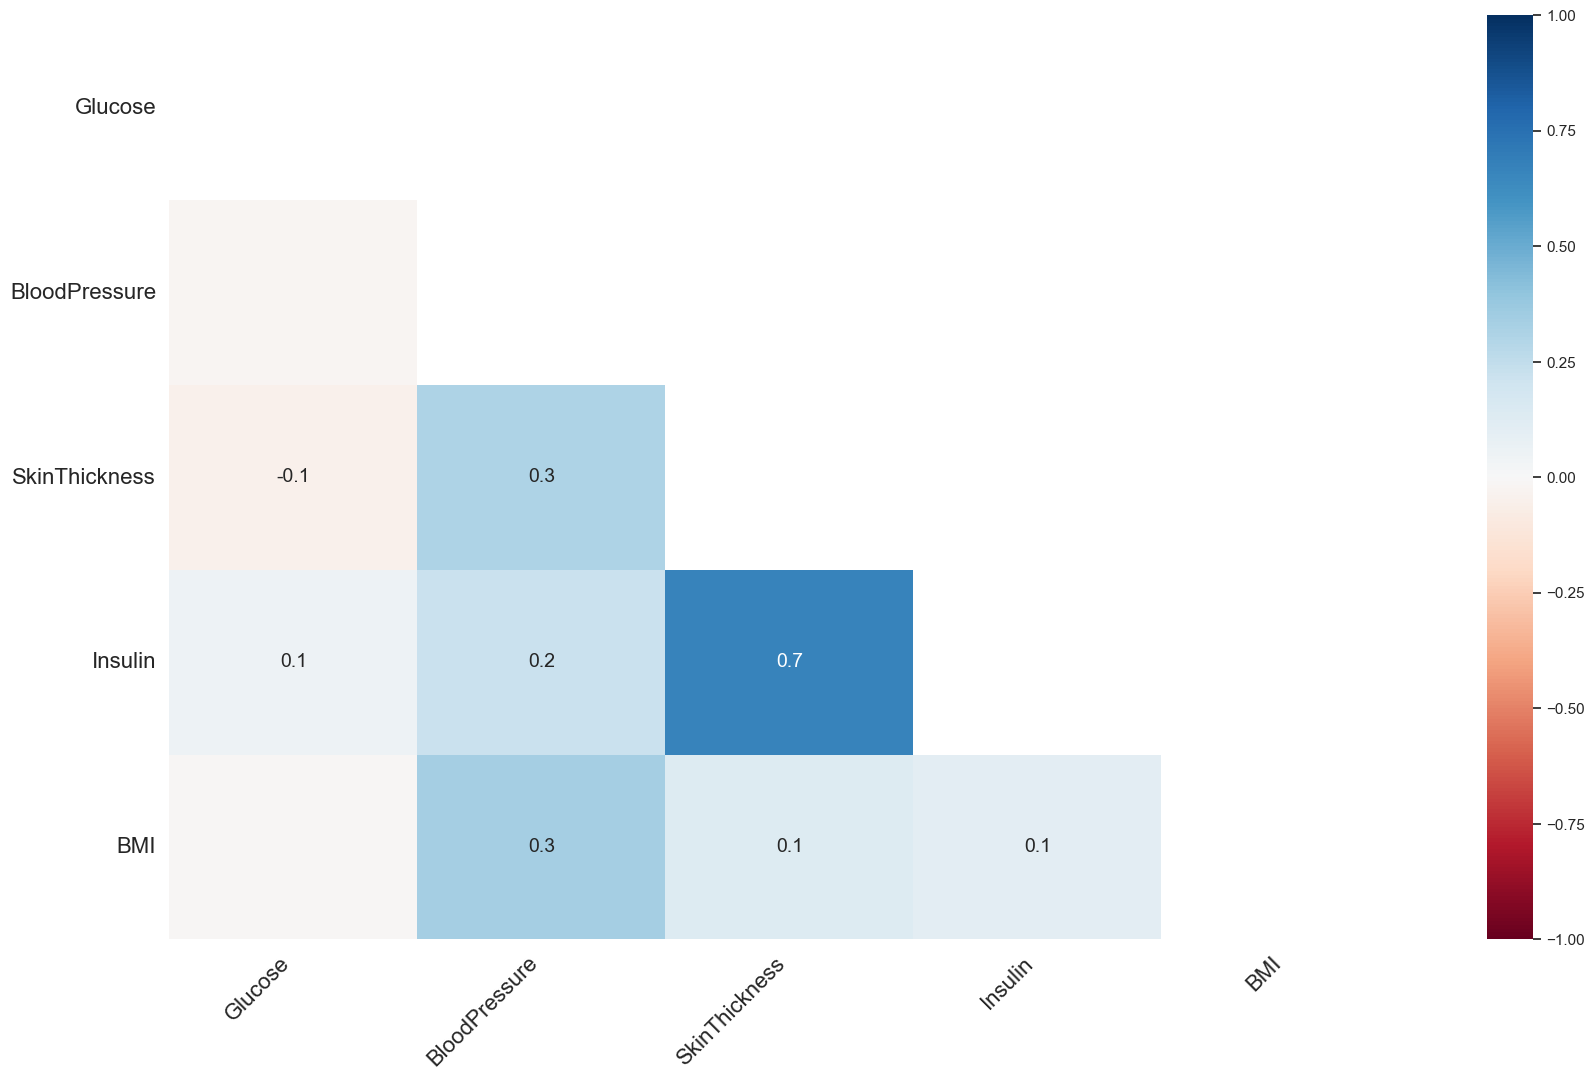

In [12]:
# Eksik Gözlem Analizi
df.isnull().sum()


msno.bar(df)
plt.show()


msno.matrix(df)
plt.show()

msno.heatmap(df)
plt.show()

In [13]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(df, na_name=True)


# Eksik Değerlerin Bağımlı Değişken ile İlişkisinin İncelenmesi
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")


missing_vs_target(df, "Outcome", na_columns)



# Eksik Değerlerin Doldurulması
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()


df.isnull().sum()




               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650
                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


                       TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                            0.344    733
1                            0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [14]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

for col in df.columns:
    print(col, check_outlier(df, col))


Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False
Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


In [15]:
##################################
# ÖZELLİK ÇIKARIMI
##################################


df.loc[(df["Age"] >= 21) & (df["Age"] < 50), "NEW_AGE_CAT"] = "mature"
df.loc[(df["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

df['NEW_BMI'] = pd.cut(x=df['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])


df["NEW_GLUCOSE"] = pd.cut(x=df["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

# # Yaş ve beden kitle indeksini bir arada düşünerek kategorik değişken oluşturma 3 kırılım yakalandı
df.loc[(df["BMI"] < 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "underweightmature"
df.loc[(df["BMI"] < 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "underweightsenior"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthymature"
df.loc[((df["BMI"] >= 18.5) & (df["BMI"] < 25)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthysenior"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "overweightmature"
df.loc[((df["BMI"] >= 25) & (df["BMI"] < 30)) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "overweightsenior"
df.loc[(df["BMI"] > 18.5) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obesemature"
df.loc[(df["BMI"] > 18.5) & (df["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obesesenior"

# Yaş ve Glikoz değerlerini bir arada düşünerek kategorik değişken oluşturma
df.loc[(df["Glucose"] < 70) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "lowmature"
df.loc[(df["Glucose"] < 70) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "lowsenior"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normalmature"
df.loc[((df["Glucose"] >= 70) & (df["Glucose"] < 100)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normalsenior"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hiddenmature"
df.loc[((df["Glucose"] >= 100) & (df["Glucose"] <= 125)) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hiddensenior"
df.loc[(df["Glucose"] > 125) & ((df["Age"] >= 21) & (df["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "highmature"
df.loc[(df["Glucose"] > 125) & (df["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "highsenior"


def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)

df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"]

df.columns = [col.upper() for col in df.columns]

df.head()




,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,senior,Obese,Prediabetes,obesesenior,highsenior,Normal,18500.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,mature,Overweight,Normal,obesemature,normalmature,Normal,10625.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,mature,Healthy,Prediabetes,obesemature,highmature,Normal,22875.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,mature,Overweight,Normal,obesemature,normalmature,Normal,8366.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,mature,Obese,Normal,obesemature,highmature,Abnormal,23016.000


In [16]:
cat_cols, num_cols = grab_col_names(df)

Observations: 768
Variables: 16
cat_cols: 7
num_cols: 9
cat_but_car: 0
num_but_cat: 3


In [17]:
binary_cols=[col for col in df.columns if df[col].nunique()==2 and col not in ["OUTCOME"]]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

for col in binary_cols:
    label_encoder(df,col)


df.head()




,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,Obese,1,obesesenior,highsenior,1,18500.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,Overweight,0,obesemature,normalmature,1,10625.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,Healthy,1,obesemature,highmature,1,22875.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,Overweight,0,obesemature,normalmature,1,8366.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,Obese,0,obesemature,highmature,0,23016.000


In [18]:
ohe_cols=[col for col in df.columns  if 10>= df[col].nunique() >2]
ohe_cols
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first,dtype=int)
    return dataframe


df =one_hot_encoder(df,ohe_cols,True)

In [19]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_GLUCOSE,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,1,18500.000,0,0,1,1,0,0,0,1,0,0,0,0
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,0,0,1,10625.000,0,1,0,0,0,0,0,0,0,0,1,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,0,1,1,22875.000,1,0,0,0,0,0,1,0,0,0,0,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,0,0,1,8366.000,0,1,0,0,0,0,0,0,0,0,1,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,0,23016.000,0,0,1,0,0,0,1,0,0,0,0,0


In [20]:
y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")



#base

#Accuarcy:0.77
#Recall :0.706
#Precision :0.59
#F1: 0.64
#Auc: 0.75

Accuracy: 0.77
Recall: 0.685
Precision: 0.62
F1: 0.65
Auc: 0.74


    Value                            Feature
1   0.151                            GLUCOSE
11  0.129                NEW_GLUCOSE*INSULIN
7   0.106                                AGE
5   0.104                                BMI
6   0.103           DIABETESPEDIGREEFUNCTION
..    ...                                ...
17  0.003   NEW_AGE_GLUCOSE_NOM_hiddensenior
20  0.001      NEW_AGE_GLUCOSE_NOM_lowmature
23  0.001   NEW_AGE_GLUCOSE_NOM_normalsenior
16  0.000  NEW_AGE_BMI_NOM_underweightmature
21  0.000      NEW_AGE_GLUCOSE_NOM_lowsenior

[24 rows x 2 columns]


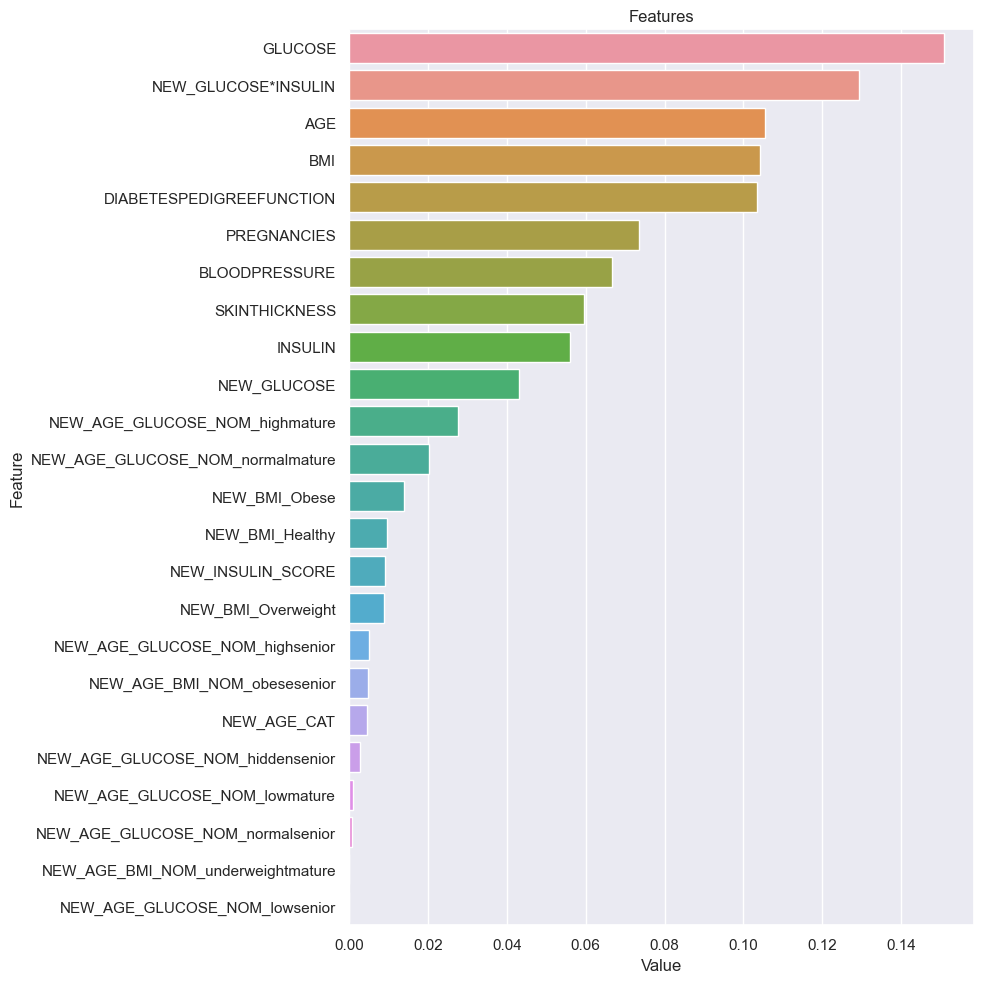

In [21]:

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sb.set(font_scale=1)
    sb.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)


